# Makemore: MLP
- Reference:
	- https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3
	- https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb

![](./AI-temp-1.png)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print("chars: ", chars)

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print("stoi: ", stoi)
print("itos: ", itos)

chars:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:  {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
print("X.shape: ", X.shape)
print("X.dtype: ", X.dtype)
print("X: ", X)

print()
print("Y.dtype: ", Y.dtype)
print("Y.shape: ", Y.shape)
print("Y: ", Y)

print()
for i in range(10):
  strlist = [itos[ix] for ix in X[i].tolist()]
  print(f"X[i](input):{X[i]} --> Y[i](label/ideal_output):{Y[i]}")
  print(f"X[i](input):{strlist} --> Y[i](label/ideal_output):{itos[Y[i].item()]}")

X.shape:  torch.Size([228146, 3])
X.dtype:  torch.int64
X:  tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

Y.dtype:  torch.int64
Y.shape:  torch.Size([228146])
Y:  tensor([ 5, 13, 13,  ..., 26, 24,  0])

X[i](input):tensor([0, 0, 0]) --> Y[i](label/ideal_output):5
X[i](input):['.', '.', '.'] --> Y[i](label/ideal_output):e
X[i](input):tensor([0, 0, 5]) --> Y[i](label/ideal_output):13
X[i](input):['.', '.', 'e'] --> Y[i](label/ideal_output):m
X[i](input):tensor([ 0,  5, 13]) --> Y[i](label/ideal_output):13
X[i](input):['.', 'e', 'm'] --> Y[i](label/ideal_output):m
X[i](input):tensor([ 5, 13, 13]) --> Y[i](label/ideal_output):1
X[i](input):['e', 'm', 'm'] --> Y[i](label/ideal_output):a
X[i](input):tensor([13, 13,  1]) --> Y[i](label/ideal_output):0
X[i](input):['m', 'm', 'a'] --> Y[i](label/ideal_output):.
X[i](input):tensor([0, 0, 0]) --> Y[i](label/ideal_output):15
X[i](input):['.', '.', 

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words): 
  # X: The inputs to the neural-network
	# Y: The matrix Y contains the labels for each example within the matrix X 
  #    (the correct letter that comes after the letters in X). 
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size # [0] * 3 = [0, 0, 0]
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# Seperate the dataset into train(80%), dev(10%), and test(10%)
# to avoid overfitting: https://www.youtube.com/watch?v=o3DztvnfAJg&ab_channel=NStatum
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [12]:
h

tensor([[-0.5345, -0.9670, -0.8198,  ...,  0.9666, -1.0000, -0.9929],
        [-0.9999,  0.9999,  0.2244,  ...,  1.0000,  0.8141,  0.2499],
        [-0.1211,  0.9236, -0.9970,  ..., -0.9995,  0.8765,  0.9883],
        ...,
        [ 0.9982, -0.9996,  1.0000,  ...,  0.5999,  0.9927, -0.9964],
        [-0.5454,  0.7584,  1.0000,  ...,  0.7788,  0.9997, -0.8460],
        [-0.3060,  0.2539,  0.9975,  ...,  0.9998,  1.0000, -0.9824]])

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [15]:
logits = h @ W2 + b2

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()

In [18]:
prob = counts / counts.sum(1, keepdims=True)

In [19]:
print(prob.shape)
print(Y.shape)
print(Y.size(0))

torch.Size([228146, 27])
torch.Size([228146])
228146


In [20]:
arranged_tensor = torch.arange(Y.size(0))
loss = -prob[arranged_tensor, Y].log().mean()
print(arranged_tensor)
print(loss)

tensor([     0,      1,      2,  ..., 228143, 228144, 228145])
tensor(14.8947)


In [21]:
# ------------ now made respectable :) ---------------

In [22]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [23]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # Each letter has 10 dimensional embbeding

# Hidden layer
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

# Output layer
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [25]:
for p in parameters:
  p.requires_grad = True

torch.Size([1000])
torch.Size([1000])


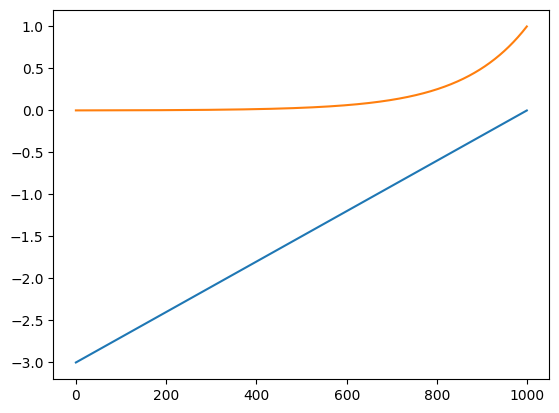

In [39]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
print(lre.shape)
print(lrs.shape)
plt.plot(torch.arange(lre.size(0)), lre)
plt.plot(torch.arange(lrs.size(0)), lrs)

In [27]:
lri = []
lossi = []
stepi = []

In [28]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass ###################################################
  emb = C[Xtr[ix]] # (32, 3, 10)
  
  # The calculation of hidden layer #########
	#<emb.view(-1, 6) @ W1 + b1> is the same as
		#torch.cat(emb[:,0:],emb[:,1:],emb[:,2:], 1) # the 2nd param is the dimension
	#The number "-1" means telling pytorch to find the length in that dimension of the metrix automatically
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  ###########################################
  
  # The calculation of output layer #########
  logits = h @ W2 + b2 # (32, 27)
  
  # Calculate the negative log likelihood loss
	#counts = logits.exp()
	#prob = counts / counts.sum(1, keepdims=True)
	#loss = -prob[torch.arrange(len[Y.item()]),Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])
  ###########################################
  ##################################################################
  
  # backward pass ##################################################
  for p in parameters:
    p.grad = None
  loss.backward()
  ##################################################################
  
  # update (take a step in the direction of the highest gradient descent)
  #(learning rate) lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

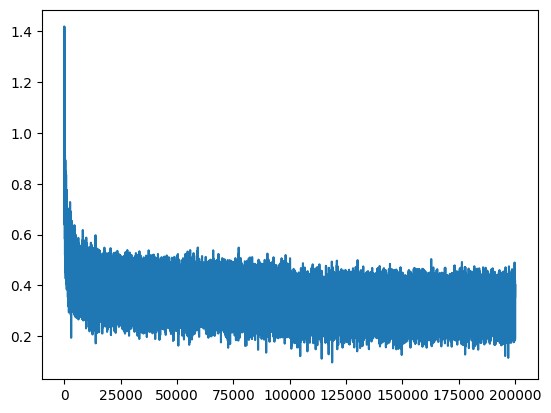

In [29]:
plt.plot(stepi, lossi)

In [ ]:
# Validate the training model to see if it is overfitting

In [47]:
print("C: ",C.shape) # C = torch.randn((27, 10), generator=g)
print("Xtr: ",Xtr.shape) # 80% of the dataset
print("Xdev: ",Xdev.shape) # 10% of the dataset

C:  torch.Size([27, 10])
Xtr:  torch.Size([182625, 3])
Xdev:  torch.Size([22655, 3])


In [48]:
print("Xtr: ",Xtr) # 80% of the dataset
print("Xdev: ",Xdev) # 10% of the dataset

Xtr:  tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])
Xdev:  tensor([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 13],
        ...,
        [ 8,  1, 25],
        [ 1, 25, 12],
        [25, 12,  1]])


In [44]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1200, grad_fn=<NllLossBackward0>)

In [31]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1551, grad_fn=<NllLossBackward0>)

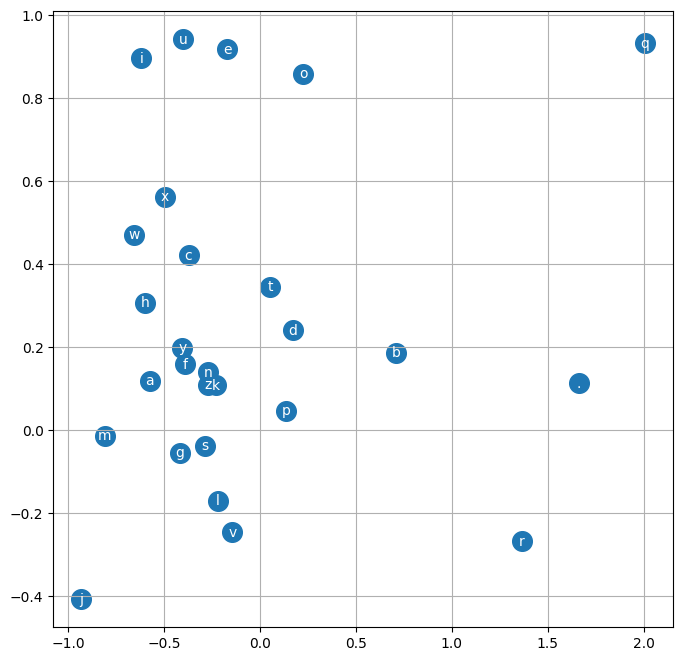

In [32]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [33]:
# training split, dev/validation split, test split
# 80%, 10%, 10%
# to avoid overfitting: https://www.youtube.com/watch?v=o3DztvnfAJg&ab_channel=NStatum

In [34]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [35]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
mel.
rylla.
emmrettep.
leg.
adee.
daeliigeli.
jenleigh.
sananarielle.
malaia.
noshubergiagriel.
kendreelle.
xithairous.
kaven.
kylene.
els.
kaysh.
skeyah.
